### Imports

In [62]:
import numpy as np
import pandas as pd
import ace_tools_open as tools
from case_studies import *
import time
import matplotlib.pyplot as plt

In [63]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f3, f4, f5]
dfs = [df1, df3, df4, df5]
Hfs = [Hf1, Hf3, Hf4, Hf5]
fnames = ["f1", "f3", "f4", "f5"]

In [64]:
def backtracking_line_search(f, df, x, pk, alpha_init, c1, rho):
    alpha = alpha_init
    while f(x + alpha * pk) > f(x) + c1 * alpha * np.dot(df(x), pk):
        alpha *= rho
        
    return alpha

### Newtons Method

In [65]:
def newtons_method_constrained(f, df, Hf, x0, A, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    x = x0
    xs = [x0]

    AAT_inv = np.linalg.inv(np.dot(A, A.T))
    
    last_term = np.dot(A.T, np.dot(AAT_inv, A))
    
    I = np.eye(last_term.shape[0], last_term.shape[1])
    
    M = I - last_term
    
    for _ in range(max_iters):
        grad = df(x) #(n,)
        hessian = Hf(x) #(n,n)
        
        if np.all(np.linalg.eigvals(hessian) > 0):
            B = hessian
        else:
            eigvals, eigvecs = np.linalg.eigh(hessian)
            B = sum(np.abs(eigval) * np.outer(eigvec, eigvec) for eigval, eigvec in zip(eigvals, eigvecs.T))
        
        #Prepare linear system of equations
        m, n = A.shape
        top = np.hstack([B, A.T])
        bottom = np.hstack([A, np.zeros([m, m])])
        lhs_matrix = np.vstack([top, bottom])
        rhs = np.vstack([-grad.reshape(-1, 1), np.zeros([m, 1])]) #(n, 1), (m, 1)

        #Solve linear system to get search direction vec and lambdas
        solution = np.linalg.solve(lhs_matrix, rhs) #(n+m, 1), p in R^n and lambda in R^m
        p = solution[:n].flatten() #(n,)
        lambdas = solution[n:].flatten() #(m,)
        
        #Find step size
        alpha = backtracking_line_search(f, df, x, p, 1.0, c1, rho)
        x = x + alpha * p #
        xs.append(x)
        
        #print(f"Stopping condition: {np.linalg.norm(grad - A.T @ lambdas)}, {f.__name__}")
        print(f"Stopping condition: {np.linalg.norm(np.dot(M, grad))}, {f.__name__}")
        if np.linalg.norm(np.dot(M, grad)) < tol:
            break

    return x, xs

### Steepest Descent

In [66]:
def steepest_descent_constrained(f, df, x0, A, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    x = x0
    xs = [x0]
    beta = 1
    
    AAT_inv = np.linalg.inv(np.dot(A, A.T))
    
    last_term = np.dot(A.T, np.dot(AAT_inv, A))
    
    I = np.eye(last_term.shape[0], last_term.shape[1])
    
    M = I - last_term

    for _ in range(max_iters):
        grad = df(x)
        p = np.dot(-M, grad)
        alpha = backtracking_line_search(f, df, x, p, beta, c1, rho)
        x = x + alpha * p
        beta = alpha / rho
        xs.append(x)


        
        print(f"Stopping condition: {np.linalg.norm(np.dot(M, grad))}, {f.__name__}")
        if np.linalg.norm(np.dot(M, grad)) < tol:
            break

    return x, xs


In [67]:
def generate_constraint(m, n, fname):
    A = np.random.randn(m, n)
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    S = np.linspace(0.1, 2, m)
    A = U @ np.diag(S) @ Vt

    x_unconstrained_optimum = x_opt(fname, n)
    offset = np.random.randn(n)
    b = - A @ (x_unconstrained_optimum + offset)

    x = np.linalg.lstsq(A, -b, rcond=None)[0]

    return A, b, x

# Example Usage:
A, b, x = generate_constraint(4, 5, "f4")
print("A:", A, "\n")
print("b:", b, "\n")
print("x:", x)
# print(A @ x)

A: [[ 0.64096166 -0.48026078 -0.45919714  0.42612466 -0.43643415]
 [ 0.59728085 -0.39026811  0.21856434  0.74899232 -0.3918658 ]
 [-0.44266775  0.42200366 -0.90426055 -0.79968    -0.39603652]
 [ 0.58188125 -0.05822011  0.18576024  0.35795707 -1.1946148 ]] 

b: [0.96553803 0.4056431  0.93784255 0.80035375] 

x: [ 0.30004046 -0.14396261  1.19647781 -0.80288428  0.76860181]


In [68]:
def benchmark(f, df, optimizer, x0, A, x_opt, Hf=None):
    start_time = time.time()
    if optimizer == newtons_method_constrained:
        x_final, xs = optimizer(f, df, Hf, x0, A)
    if optimizer == steepest_descent_constrained:
        x_final, xs = optimizer(f, df, x0, A)
    end_time = time.time()

    num_iterations = len(xs)
    final_solution_point = x_final
    dist_to_optimum = np.linalg.norm(x_final-x_opt)
    final_fun_value = f(xs[-1])
    duration = end_time-start_time
    
    grad_norms = [np.linalg.norm(df(x)) for x in xs]

    return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms, grad_norms[-1])


In [69]:
SEED = 10
np.random.seed(SEED)
d = 20
m = 5
num_runs = 1
benchmark_results = []

#NEED TO DEFINE A WITH LINEAR EQUALITY CONSTRAINTS??

for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(f, d)

    #Newtons Method constrained
    for _ in range(num_runs):
        
        A, _, x0 = generate_constraint(m, d, fname)

        nm_result = benchmark(f, df, newtons_method_constrained, x0, A, x_optimal, Hf)
        benchmark_results.append((fname, "Newtons Method Constrained") + nm_result)

        #Steepest Descent
        sd_result = benchmark(f, df, steepest_descent_constrained, x0, A, x_optimal)
        benchmark_results.append((fname, "Steepest Descent Constrained") + sd_result)
        
#Organize in dataframe
columns = ["Function", "Optimizer", "Iterations", "Time", "Final Function Value", "Final Solution Point", "Distance to Optimum", "Gradient Norms", "Final Gradient Norm"]
df_results = pd.DataFrame(benchmark_results, columns=columns)

df_display = df_results.drop(columns=["Final Solution Point", "Gradient Norms"])
tools.display_dataframe_to_user(name="Benchmark Results", dataframe=df_display)

Stopping condition: 1200.2811357049056, f1
Stopping condition: 7.913958172890805e-13, f1
Stopping condition: 1200.2811357049056, f1
Stopping condition: 1261.7206317714601, f1
Stopping condition: 1259.7782073233475, f1
Stopping condition: 1271.579268389449, f1
Stopping condition: 1285.0429299217508, f1
Stopping condition: 1299.3666922630835, f1
Stopping condition: 1054.1863673261198, f1
Stopping condition: 855.4238485788072, f1
Stopping condition: 865.1201082192828, f1
Stopping condition: 702.1046655931837, f1
Stopping condition: 710.1607928013481, f1
Stopping condition: 576.4564709226287, f1
Stopping condition: 583.1081771593066, f1
Stopping condition: 589.9129931249525, f1
Stopping condition: 478.9196036156973, f1
Stopping condition: 484.5034096241494, f1
Stopping condition: 490.19164457104836, f1
Stopping condition: 495.97682281859426, f1
Stopping condition: 402.70135485088457, f1
Stopping condition: 407.43259110937896, f1
Stopping condition: 412.238780697179, f1
Stopping condition: 

Stopping condition: 0.8049693820913081, f1
Stopping condition: 0.8146473484740805, f1
Stopping condition: 0.8244444215442115, f1
Stopping condition: 0.6695881973461073, f1
Stopping condition: 0.6776095324684877, f1
Stopping condition: 0.6857301763212843, f1
Stopping condition: 0.6939512927502722, f1
Stopping condition: 0.7022740605130074, f1
Stopping condition: 0.7106996734377348, f1
Stopping condition: 0.719229340599748, f1
Stopping condition: 0.7278642864847245, f1
Stopping condition: 0.736605751169618, f1
Stopping condition: 0.7454549904905795, f1
Stopping condition: 0.754413276228474, f1
Stopping condition: 0.7634818962814562, f1
Stopping condition: 0.7726621548552716, f1
Stopping condition: 0.7819553726405876, f1
Stopping condition: 0.6350667022677167, f1
Stopping condition: 0.642675758178282, f1
Stopping condition: 0.6503789926268945, f1
Stopping condition: 0.6581775098370591, f1
Stopping condition: 0.6660724281707207, f1
Stopping condition: 0.6740648802786388, f1
Stopping condit

In [70]:
df_avg_results = df_results.groupby(["Function", "Optimizer"]).agg({
    "Iterations": "mean",
    "Time": "mean",
    "Final Function Value": "mean",
    "Distance to Optimum": "mean",
    "Final Gradient Norm": "mean"
}).reset_index()

# Display the final averaged results
tools.display_dataframe_to_user(name="Averaged Optimization Results", dataframe=df_avg_results)

Averaged Optimization Results


In [71]:
df_avg_results_no_scipy = df_avg_results[df_avg_results["Optimizer"] != "scipy BFGS"]
tools.display_dataframe_to_user(name="Averaged Optimization Results", dataframe=df_avg_results)

Averaged Optimization Results


In [72]:
def extract_grad_norms(df, function_name, optimizer_name):
    return df[(df["Function"] == function_name) &  (df["Optimizer"] == optimizer_name)]["Gradient Norms"].tolist()


def pad_grad_norms(grad_norms_list):
    max_length_run = max(len(run) for run in grad_norms_list)
    #print(max_length_run)
    padded_runs = []

    for run in grad_norms_list:
        padded_run = np.pad(run, (0, max_length_run - len(run)), mode="constant", constant_values=0)
        padded_runs.append(padded_run)
    
    return padded_runs

def get_avg_grad_norms(df, function_name, optimizer_name):

    grad_norms = extract_grad_norms(df, function_name, optimizer_name)
    padded_grad_norms = pad_grad_norms(grad_norms)
    mean_grad_norms = np.mean(padded_grad_norms, axis=0)

    return mean_grad_norms

In [73]:
f1_newton_avg = get_avg_grad_norms(df_results, "f1", "Newtons Method")
f3_newton_avg = get_avg_grad_norms(df_results, "f4", "Newtons Method")
f4_newton_avg = get_avg_grad_norms(df_results, "f4", "Newtons Method")
f5_newton_avg = get_avg_grad_norms(df_results, "f4", "Newtons Method")

f1_sd_avg = get_avg_grad_norms(df_results, "f1", "Steepest Descent")
f3_sd_avg = get_avg_grad_norms(df_results, "f3", "Steepest Descent")
f4_sd_avg = get_avg_grad_norms(df_results, "f4", "Steepest Descent")
f5_sd_avg = get_avg_grad_norms(df_results, "f5", "Steepest Descent")



ValueError: max() iterable argument is empty

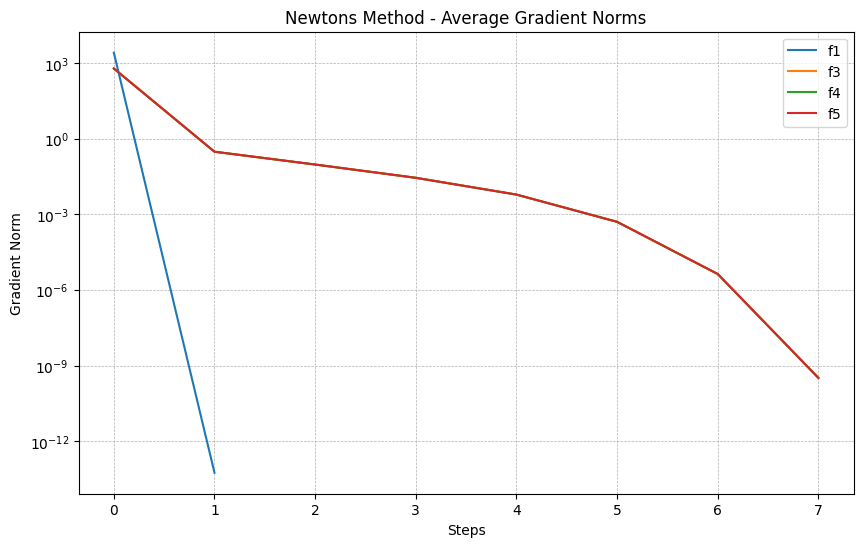

NameError: name 'f1_bfgs_avg' is not defined

In [ ]:
def plot_convergence(title, f1_avg, f3_avg, f4_avg, f5_avg):
    plt.figure(figsize=(10, 6))

    plt.plot(range(len(f1_avg)), f1_avg, label="f1")
    plt.plot(range(len(f3_avg)), f3_avg, label="f3")
    plt.plot(range(len(f4_avg)), f4_avg, label="f4")
    plt.plot(range(len(f5_avg)), f5_avg, label="f5")

    plt.xlabel("Steps")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

def plot_convergence_AN(title, f1_avg, f4_avg):
    plt.figure(figsize=(10, 6))

    plt.plot(range(len(f1_avg)), f1_avg, label="f1")
    plt.plot(range(len(f4_avg)), f4_avg, label="f4")

    plt.xlabel("Steps")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

plot_convergence("Newtons Method - Average Gradient Norms", f1_newton_avg, f3_newton_avg, f4_newton_avg, f5_newton_avg)
plot_convergence("Steepest Descent - Average Gradient Norms", f1_sd_avg, f3_sd_avg, f4_sd_avg, f5_sd_avg)
